# **Introduction à l'apprentissage automatique**

Il est maintenant temps de tenter de prédire le rendement d'avoine en fonction des variables que nous avons récupérées. 




Nous ne traiterons pas le jeu de données comme une série chronologique.  
L'année, bien que présente, sera considérée comme une caractéristique dans le jeu de données.  
Nous ne voulons pas prédire le rendement futur en nous basant sur le passé.  Nous tenterons plutôt de prédire le rendement compte tenu des caractéristiques actuelles comme la température et la quantité de précipitations.

## Rappel 

Pour l'apprentissage supervisé, par convention, nous utilisons deux matrices, soient $X$ et $y$. 

$X$, contient les caractéristiques (*features*) et est de taille $n \times p$, où $n$ est le nombre d'exemples (observations) et $p$ est le nombre de caractéristiques (dimensionnalité).

$$X = \begin{bmatrix} 
f_{11} & f_{12} & \ldots & f_{1p} \\
\vdots & \vdots       &  \ddots      & \vdots \\ 
f_{n1} & f_{12} & \ldots & f_{np} \\
\end{bmatrix}
$$ 



$y$, est en fait un vecteur qui contient les étiquettes associées à chaque exemple. Il est donc de taille $n$. 


$$
y = \begin{bmatrix} 
e_1 \\
e_2 \\
\vdots \\ 
e_n
\end{bmatrix}$$

$X$ et $y$ doivent toujours être ordonnés de la même façon, i.e. pour un index $i$, les données de $X_i$ correspondent à l'étiquette $y_i$.



Comme nous entrainons des modèles sur un ensemble d'entrainement (`train`) et testons leurs performances sur un ensemble de test (`test`), nous dénotons ces ensembles comme $X_\text{train}$ et $X_\text{test}$ et $Y_\text{train}$ et $Y_\text{test}$.

## Installation et chargement des librairies nécessaires

Nous devons d'abord charger (et possiblement installer) les librairies nécessaires.  Voici une description de certaines des librairies utilisées.
- `missingo` permet de visualiser rapidement les données manquantes
- `sklearn`  scikit-learn est un incontournable pour faire de l'apprentissage automatique
- `matplotlib` et `seaborn` pour générer des graphiques
- `numpy` pour des opérations d'algèbres linéaires et mathématiques
- `pandas` pour faciliter la manipulation et la structure des données (parfois lent pour les gros jeux de données)

In [1]:
#!pip install missingno
#!pip install statsmodels
#!pip install scikit-learn 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import missingno
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier, BaggingRegressor,
                              GradientBoostingRegressor, GradientBoostingClassifier)
from sklearn.neural_network import MLPRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.datasets import make_regression
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score, f1_score, mean_absolute_error,
                            confusion_matrix, classification_report, roc_auc_score, recall_score)


sns.set(font_scale=0.9, style='whitegrid')
colors = ["#40BEAD", "#248CC4", "#308E81", "#576AC9"] # IVADO palette

%matplotlib inline

In [3]:
# Le random seed est défini pour permettre de reproduire les résultats
random_seed = 42

## Chargement des données

Nous allons utiliser les données que nous avons préparées lors de la séance de Nettoyage de données.

Le jeu de données contient des données météorologiques et de rendement d'avoine collectées entre 2004 et 2022 pour un nombre de régions ontariennes.

Nous voulons prédire le rendement d'avoine.  La tâche relève donc de l'apprentissage supervisé et est une tâche de régression.  

Nous voulons prédire un nombre et non une catégorie (étiquette).

In [4]:
file_id = '1jnO2s6eNAW-ORZFwqAXjNA3FDg3w6LiC'
url = "https://drive.google.com/uc?export=view&id=%s" % file_id
df = pd.read_csv(url, index_col=0)

# Ou charger le fichier sauvegardé localement
# df = pd.read_csv('dataset_v1.csv', index_col=0)

Rappel : de quoi a l'air la distribution de la variable cible à prédire ? Nous voulons prédire le rendement d'avoine en boisseau / acre récolté * 1000

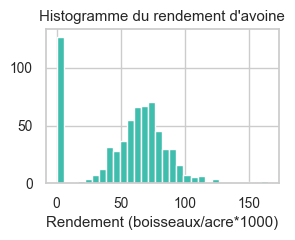

In [5]:
_ = plt.figure(figsize=(3,2))
df.Rendement.hist(bins=30, color=colors[0])
plt.title("Histogramme du rendement d'avoine")
plt.xlabel("Rendement (boisseaux/acre*1000)")
plt.show()

A-t-on des valeurs manquantes ? 

Certains algorithmes d'apprentissage automatique ne supportent pas les valeurs manquantes.  Nous devons donc les imputer ou les éliminer.  Lorsque nous avons un petit nombre d'exemples, nous voulons souvent en conserver le maximum, donc l'élimination n'est pas une option envisageable.

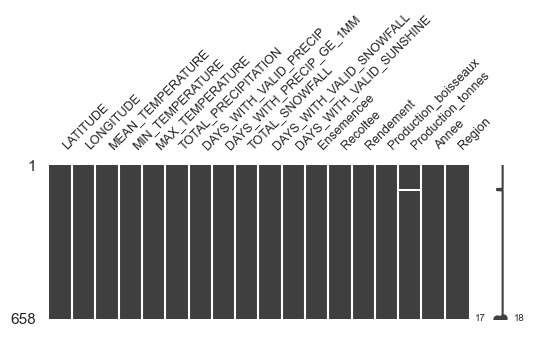

In [6]:
# Visualisons les valeurs manquantes
missingno.matrix(df, figsize=(6,2), fontsize=9)
plt.show()

Nous avons quelques valeurs de NaN pour la production de boisseaux en tonnes.

Le graphique de `missingo` ne présente que les NaN.  Qu'en est-il du rendement égal à  0 ?

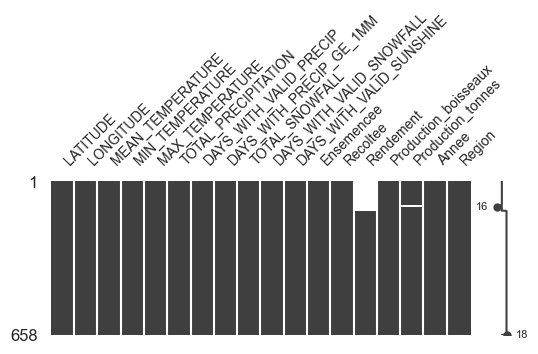

In [7]:
mx = df.copy()
mx.loc[mx.Rendement==0, 'Rendement'] = np.nan
missingno.matrix(mx, figsize=(6,2), fontsize=10)
plt.show()

Nous en avons discuté lors de la séance sur le nettoyage de données, est-ce qu'une valeur de 0 signifie réellement 0 ?  Y a-t-il des cas pour lesquels la valeur de rendement est de 0 mais la production de boisseaux est non nulle ?

In [8]:
df.loc[(df.Rendement == 0) & (df.Production_boisseaux != 0), :]

,LATITUDE,LONGITUDE,MEAN_TEMPERATURE,MIN_TEMPERATURE,MAX_TEMPERATURE,TOTAL_PRECIPITATION,DAYS_WITH_VALID_PRECIP,DAYS_WITH_PRECIP_GE_1MM,TOTAL_SNOWFALL,DAYS_WITH_VALID_SNOWFALL,DAYS_WITH_VALID_SUNSHINE,Ensemencee,Recoltee,Rendement,Production_boisseaux,Production_tonnes,Annee,Region
0,45.054,-76.784,9.797829,-24.0,32.5,901.4,352.0,120.0,168.8,352.0,0.0,27.592198,23.281722,0.0,0.796741,0.016182,2021,Frontenac
0,44.403,-76.908,10.057898,-23.5,34.0,815.9,360.0,111.0,115.8,360.0,0.0,1122.657562,947.275062,0.0,38.955752,0.791191,2021,Lennox And Addington


Nous n'avons que deux cas où le rendement est 0 et la production de boisseaux n'est pas 0. Est-ce une erreur?

Comme nous voulons prédire le rendement, nous ne garderons que les exemples qui ont une valeur de rendement supérieure à 0.

In [9]:
df = df.loc[df.Rendement > 0, :].reset_index()
df = df.iloc[:,1:]

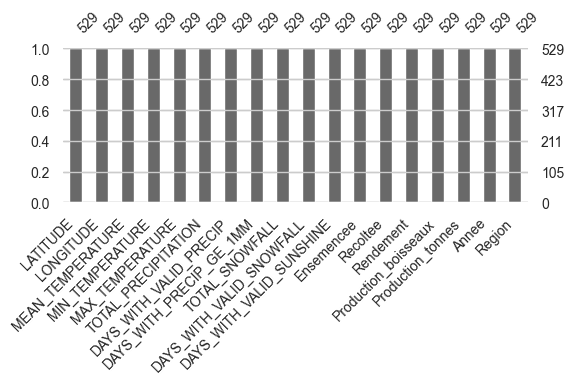

In [10]:
# Autre façon de visualiser les données manquantes.
missingno.bar(df, figsize=(6,2), fontsize=10)
plt.show()

In [11]:
# Nombre de données manquantes par variable
df.isna().sum(0)

LATITUDE                    0
LONGITUDE                   0
MEAN_TEMPERATURE            0
MIN_TEMPERATURE             0
MAX_TEMPERATURE             0
TOTAL_PRECIPITATION         0
DAYS_WITH_VALID_PRECIP      0
DAYS_WITH_PRECIP_GE_1MM     0
TOTAL_SNOWFALL              0
DAYS_WITH_VALID_SNOWFALL    0
DAYS_WITH_VALID_SUNSHINE    0
Ensemencee                  0
Recoltee                    0
Rendement                   0
Production_boisseaux        0
Production_tonnes           0
Annee                       0
Region                      0
dtype: int64

In [12]:
df.isnull().any()

LATITUDE                    False
LONGITUDE                   False
MEAN_TEMPERATURE            False
MIN_TEMPERATURE             False
MAX_TEMPERATURE             False
TOTAL_PRECIPITATION         False
DAYS_WITH_VALID_PRECIP      False
DAYS_WITH_PRECIP_GE_1MM     False
TOTAL_SNOWFALL              False
DAYS_WITH_VALID_SNOWFALL    False
DAYS_WITH_VALID_SUNSHINE    False
Ensemencee                  False
Recoltee                    False
Rendement                   False
Production_boisseaux        False
Production_tonnes           False
Annee                       False
Region                      False
dtype: bool

Comme il n'y a pas de valeurs manquantes, nous allons en créer pour tester les méthodes d'imputation. Nous allons ajouter des valeurs manquantes à la variable `TOTAL_SNOWFALL`.

In [13]:
df.loc[df.sample(10).index, 'TOTAL_SNOWFALL'] = np.nan 
df.isna().sum(0)  # Nombre de données manquantes par variable

LATITUDE                     0
LONGITUDE                    0
MEAN_TEMPERATURE             0
MIN_TEMPERATURE              0
MAX_TEMPERATURE              0
TOTAL_PRECIPITATION          0
DAYS_WITH_VALID_PRECIP       0
DAYS_WITH_PRECIP_GE_1MM      0
TOTAL_SNOWFALL              10
DAYS_WITH_VALID_SNOWFALL     0
DAYS_WITH_VALID_SUNSHINE     0
Ensemencee                   0
Recoltee                     0
Rendement                    0
Production_boisseaux         0
Production_tonnes            0
Annee                        0
Region                       0
dtype: int64


## Imputation des valeurs manquantes
Il existe plusieurs stratégies pour gérer les valeurs manquantes.  Il faut faire bien attention pour ne pas introduire de biais et pour ne pas créer une fuite de données (*data leakage*). 

C'est pourquoi nous séparons nos données en ensemble d'entrainement et de test *avant* de faire l'imputation.
Le choix de la méthode d'imputation peut devenir un hyper-paramètre à ajuster dans notre protocole. 

Nous allons d'abord passer à travers quelques-unes des étapes une à une.  
Nous utiliserons ensuite les fonctions de `Pipeline` de `scikit-learn`.


### Création de la matrice $X$ et du vecteur $y$

In [14]:
# Rappel, variables inclues dans le jeu de données
df.columns

Index(['LATITUDE', 'LONGITUDE', 'MEAN_TEMPERATURE', 'MIN_TEMPERATURE',
       'MAX_TEMPERATURE', 'TOTAL_PRECIPITATION', 'DAYS_WITH_VALID_PRECIP',
       'DAYS_WITH_PRECIP_GE_1MM', 'TOTAL_SNOWFALL', 'DAYS_WITH_VALID_SNOWFALL',
       'DAYS_WITH_VALID_SUNSHINE', 'Ensemencee', 'Recoltee', 'Rendement',
       'Production_boisseaux', 'Production_tonnes', 'Annee', 'Region'],
      dtype='object')

Nous allons choisir un sous-ensemble de variables et réordonner les colonnes, en plus de définir $X$ et $y$

In [15]:
cols = ['DAYS_WITH_VALID_SUNSHINE','DAYS_WITH_VALID_PRECIP', 
        'MEAN_TEMPERATURE', 'MIN_TEMPERATURE','DAYS_WITH_PRECIP_GE_1MM','TOTAL_SNOWFALL', 
        'MAX_TEMPERATURE', 'TOTAL_PRECIPITATION', 'Annee', 'LATITUDE', 'LONGITUDE']

X = df.loc[:, cols]  # Caractéristiques (température, precipitation, etc.)
y = df.Rendement  # Valeurs cibles (rendement)

### Avant de commencer

Tel que dit précédemment, nous allons utiliser les fonction de `scikit-learn` dans ce notebook.

Les classes de `scikit-learn` implémentant des transformations s'utilisent toujours de la même façon : en utilisant les méthodes `fit` et `transform`. 

Nous verrons que les classes implémentant des prédicteurs fonctionnent aussi de façon similaire : avec les méthodes `fit` et `predict`. 

On utilise les méthodes `fit` et `fit_transform` que sur l'ensemble d'entrainement, jamais sur l'ensemble de test.



Pour tout projet d'apprentissage automatique, il faut faire attention à: 

* la fuite de données
* la cohérence dans l'application du pré-traitement
* l'utilisation du *random seed*


### Création des ensembles d'entrainement et de test

In [16]:
# Division des données en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=random_seed)


L'ensemble de test doit être mis de côté et on ne doit pas y toucher avant l'évaluation finale de notre modèle. 


Pourquoi fixer le *random_seed* ? Parce que les processus stochastiques impliqués ne donneront pas les mêmes résultats s'il n'est pas fixé.  On s'assure de reproduire le même résultat.

In [17]:
print(y_test.index)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=random_seed)
print(y_test.index)

Int64Index([140, 397,   6, 334, 322,  82, 225, 495, 522, 101,
            ...
             93, 316, 172, 433, 377, 340, 457, 131, 338, 513],
           dtype='int64', length=106)
Int64Index([140, 397,   6, 334, 322,  82, 225, 495, 522, 101,
            ...
             93, 316, 172, 433, 377, 340, 457, 131, 338, 513],
           dtype='int64', length=106)


In [18]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2)
print(y_test_.index)
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2)
print(y_test_.index)

Int64Index([142, 272, 476, 183, 444, 259, 236, 332, 109, 340,
            ...
            194,  10, 124, 150,  34, 438, 141, 151, 322, 210],
           dtype='int64', length=106)
Int64Index([254, 343, 169, 305, 120, 383, 347, 294, 267, 521,
            ...
            284, 323, 373, 303, 257, 122, 375, 423, 291, 231],
           dtype='int64', length=106)


### Imputation des valeurs manquantes en utilisant les classes de scikit-learn

In [19]:
# SimpleImputer (imputation par la moyenne)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train)

X_train_mean = pd.DataFrame(imp.transform(X_train), columns=X_train.columns, 
                            index=X_train.index)
X_test_mean = pd.DataFrame(imp.transform(X_test), columns=X_test.columns, 
                           index=X_test.index)

In [20]:
# IterativeImputer (imputation par estimation)
imp_it = IterativeImputer(max_iter=10, random_state=random_seed)
imp_it.fit(X_train)

X_train_it = pd.DataFrame(imp_it.transform(X_train), columns=X_train.columns, 
                          index=X_train.index)
X_test_it = pd.DataFrame(imp_it.transform(X_test), columns=X_test.columns, 
                         index=X_test.index)

### À votre tour  
<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

Vérifiez que la valeur imputée est bien celle attendue et qu'il n'y a pas eu de fuite de données. 

In [21]:
var = 'TOTAL_SNOWFALL'
mean_val = df.loc[X_train.index, var].mean()
print(F'''La valeur moyenne de la variable TOTAL_SNOWFALL dans l'ensemble 
      d'entrainement est de {mean_val:3.6}.''')

La valeur moyenne de la variable TOTAL_SNOWFALL dans l'ensemble 
      d'entrainement est de 110.275.


In [22]:
print('Voici 2 rangées des valeurs imputées')
ix = df.loc[df[var].isnull(),:].index

print("-----------------------")
print("Ensemble d'entrainement")
print("-----------------------")
print(X_train_mean.loc[X_train_mean.index.isin(ix),:].head(2))

Voici 2 rangées des valeurs imputées
-----------------------
Ensemble d'entrainement
-----------------------
     DAYS_WITH_VALID_SUNSHINE  DAYS_WITH_VALID_PRECIP  MEAN_TEMPERATURE  \
203                       0.0                  319.50          6.712362   
5                         0.0                  349.75          9.332913   

     MIN_TEMPERATURE  DAYS_WITH_PRECIP_GE_1MM  TOTAL_SNOWFALL  \
203          -33.375                   106.25      110.275367   
5            -17.525                   116.50      110.275367   

     MAX_TEMPERATURE  TOTAL_PRECIPITATION   Annee  LATITUDE  LONGITUDE  
203           31.500              676.100  2014.0  45.93575   -77.2965  
5             36.775              771.525  2012.0  43.00775   -82.1285  


In [23]:
print("-----------------------")
print("Ensemble de test")
print("-----------------------")
print(X_test_mean.loc[X_test_mean.index.isin(ix),:].head(2))

-----------------------
Ensemble de test
-----------------------
     DAYS_WITH_VALID_SUNSHINE  DAYS_WITH_VALID_PRECIP  MEAN_TEMPERATURE  \
486                       0.0              340.333333          8.308402   
90                        0.0              284.000000          7.889122   

     MIN_TEMPERATURE  DAYS_WITH_PRECIP_GE_1MM  TOTAL_SNOWFALL  \
486       -20.933333               103.333333      110.275367   
90        -25.300000                95.500000      110.275367   

     MAX_TEMPERATURE  TOTAL_PRECIPITATION   Annee   LATITUDE  LONGITUDE  
486            33.50           855.833333  2018.0  42.059667 -82.889333  
90             31.35           840.750000  2011.0  43.958500 -78.175000  


Comment se comparent les distributions comprenant les valeurs imputées par les deux méthodes ?

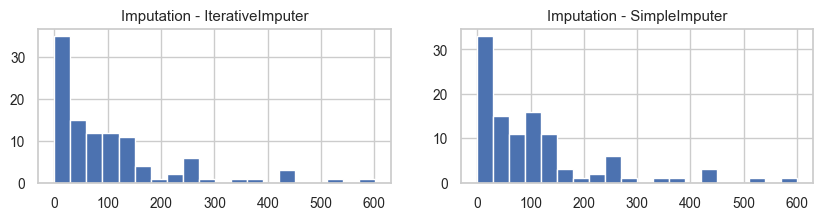

In [24]:
fig = plt.figure(figsize=(10,2))
plt.subplot(121)
X_test_it[var].hist(bins=20)
plt.title('Imputation - IterativeImputer')
plt.subplot(122)
X_test_mean[var].hist(bins=20)
plt.title('Imputation - SimpleImputer')
plt.show()

In [25]:
print("Voici les valeurs imputées dans l'ensemble de test avec la méthode itérative")
X_test_it.loc[X_test_it.index.isin(ix),:]

Voici les valeurs imputées dans l'ensemble de test avec la méthode itérative


,DAYS_WITH_VALID_SUNSHINE,DAYS_WITH_VALID_PRECIP,MEAN_TEMPERATURE,MIN_TEMPERATURE,DAYS_WITH_PRECIP_GE_1MM,TOTAL_SNOWFALL,MAX_TEMPERATURE,TOTAL_PRECIPITATION,Annee,LATITUDE,LONGITUDE
486,0.0,340.333333,8.308402,-20.933333,103.333333,76.129153,33.500000,855.833333,2018.0,42.059667,-82.889333
90,0.0,284.000000,7.889122,-25.300000,95.500000,107.191013,31.350000,840.750000,2011.0,43.958500,-78.175000
493,0.0,350.500000,9.264011,-28.150000,80.000000,1.681805,32.500000,628.100000,2015.0,42.999500,-82.304500
500,0.0,336.333333,6.815979,-26.500000,99.666667,24.910903,32.366667,638.966667,2022.0,43.778333,-80.515333
22,0.0,365.000000,7.373118,-28.000000,145.000000,175.510545,33.000000,1013.400000,2005.0,43.918000,-80.086000


Quelle méthode d'imputation choisir ?

La documentation de `scikit-learn` est très complète.  Il existe d'autres méthodes qui peuvent être utilisées. 

https://scikit-learn.org/stable/modules/impute.html

Lorsque nous parlons de données manquantes, il faut faire attention pour ne pas introduire de biais. Les données peuvent être manquantes par hasard ou elles peuvent être manquantes pour des raisons bien particulières.

Il existe trois types de données manquantes : 

* données manquantes complètement au hasard (MCAR : missing completely at random)
* données manquantes au hasard (MAR : missing at random) 
* données manquantes non au hasard (MNAR : missing not at random) 

Le type de données manquantes et le choix de la méthode d'imputation peuvent avoir un impact sur la qualité des données et sur la performance du modèle.

Pour la suite, nous utiliserons les données imputées par la méthode itérative

In [26]:
X_train = X_train_it
X_test = X_test_it

### Corrélation entre les variables


Il est important d'évaluer la corrélation entre les variables.  Les algorithmes d'apprentissage ne se comportent pas tous de la même façon.  Certains performent mieux avec des données gaussiennes, d'autres sont très sensibles aux valeurs numériques et une transformation est nécessaire, d'autres sont sensibles aux variables corrélées entre elles.

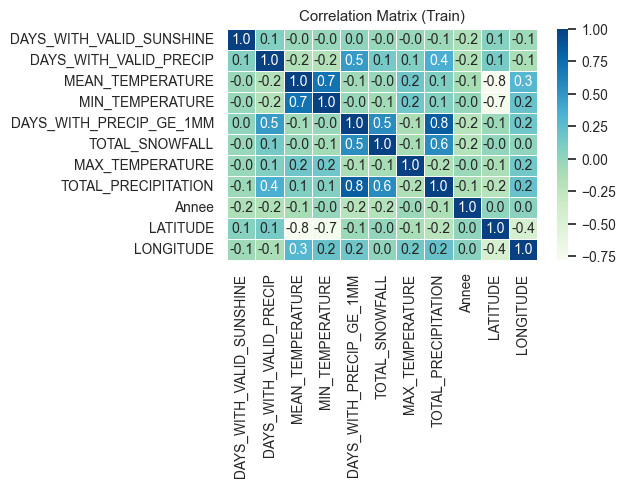

In [27]:
plt.figure(figsize=(5,3))
sns.heatmap(X_train.corr(), annot=True, fmt=".1f", cmap='GnBu', linewidths=.5, 
            annot_kws={"size": 10}).set(title='Correlation Matrix (Train)')
plt.show()

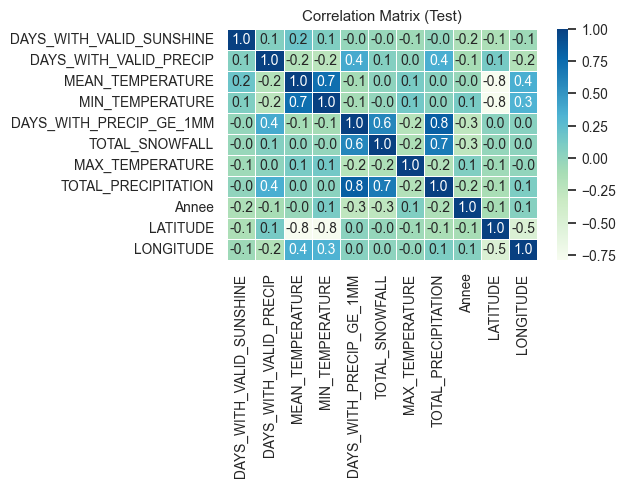

In [28]:
plt.figure(figsize=(5,3))
sns.heatmap(X_test.corr(), annot=True, fmt=".1f", cmap='GnBu', linewidths=.5, 
            annot_kws={"size": 10}).set(title='Correlation Matrix (Test)')
plt.show()

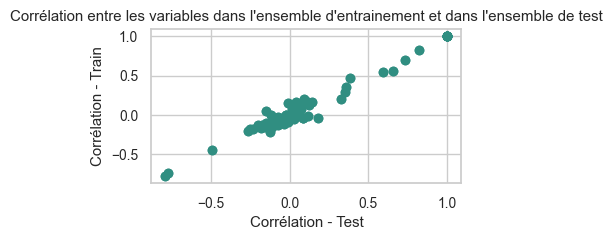

In [29]:
plt.figure(figsize=(4,2))
plt.scatter(X_test.corr(), X_train.corr(), color=colors[2])
plt.ylabel('Corrélation - Train')
plt.xlabel('Corrélation - Test')
plt.title ("Corrélation entre les variables dans l'ensemble d'entrainement et dans l'ensemble de test")
plt.show()

In [30]:
# Élimination des variables MIN_TEMPERATURE et DAYS_WITH_PRECIP_GE_1MM
cols_to_remove = ['MIN_TEMPERATURE', 'DAYS_WITH_PRECIP_GE_1MM']

X_train.drop(cols_to_remove, axis=1, inplace=True)

X_test.drop(cols_to_remove, axis=1, inplace=True)

### À votre tour  
<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

D'après vous, devrait-ton retirer l'année ? Comment devrait-on l'encoder si on ne la retire pas?

## Transformation (normalisation, standardisation, encodage)

Des transformations sont parfois nécessaires.

Nous voudrons, par exemple, utiliser un encodage One-Hot pour les variables qualitatives (catégories) ou ramener les valeurs entre 0 et 1 pour les variables qui ne sont pas du même ordre de grandeur.

Ici, nous transformerons toutes les variables en *z-score* en utilisant la classe `StandardScaler`.

https://scikit-learn.org/stable/modules/preprocessing.html

In [31]:
scaler = StandardScaler().set_output(transform="pandas")
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Prédire le rendement d'avoine

La prédiction du rendement d'avoine est une tâche de régression.  Nous voulons prédire un nombre.

Nous pourrons évaluer la performance des modèles sur nos données en regardant le coefficient de détermination ($R^2$) et la *MSE* (*mean squared error*) ou la *RMSE* (*root mean squared error*).

Le $R^2$ représente la portion de la variance de *y* pouvant être expliquée par les variables indépendantes du modèle.  Cela donne une idée de la qualité de l'ajustement, et donc de comment un nouvel exemple jamais vu pourra être prédit par le modèle.  
Le $R^2$ est typiquement entre 0 et 1, 1 voulant dire un ajustement parfait et 0 correspondant à un modèle qui prédirait à tout coup la moyenne de $y$.  
Dans `scikit-learn`, il peut prendre des valeurs négatives.

L'erreur moyenne au carré est définie comme: $\text{MSE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2.$


Il existe d'autres métriques moins fréquemment utilisées: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

Le `DummyRegressor` peut servir pour le prototypage de notre code.  Il utilise des règles très simples et expose les mêmes fonctions que les autres classes de `Regressor`. Par défaut, il prédit toujours la moyenne des cibles de l'ensemble d'entrainement.

In [32]:
dummy_regressor = DummyRegressor()
dummy_regressor.fit(X_train, y_train)
y_pred = dummy_regressor.predict(X_test)
score = dummy_regressor.score(X_test, y_test)

In [33]:
def plot_pred_vs_true(y_test, y_pred, score, model_name, y_train=None, y_train_pred=None):
    plt.figure(figsize=(4,3))
    if y_train is not None and y_train_pred is not None:
        plt.scatter(y_train, y_train_pred, label='Training data', color=colors[1])
        
    plt.scatter(y_test, y_pred, label='Test data', color=colors[0])
    plt.title('{} [test score={:.2f}]'.format(model_name, score))
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend()
    plt.ylim(y_test.min(), y_test.max())
    plt.show()

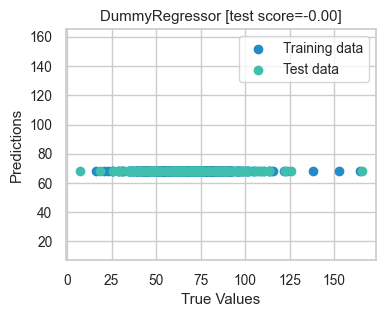

In [34]:
y_train_pred = dummy_regressor.predict(X_train)
plot_pred_vs_true(y_test, y_pred, score, 'DummyRegressor', 
                  y_train=y_train, y_train_pred=y_train_pred)

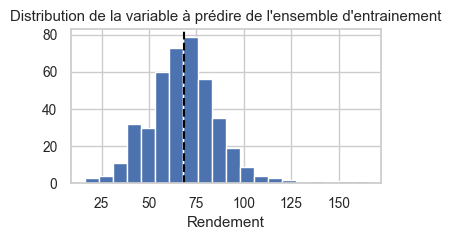

In [35]:
_ = plt.figure(figsize=(4,2))
plt.hist(y_train, bins=20)
plt.title("Cibles - ensemble d'entrainement")
plt.axvline(x=y_train.mean(), color='black', linestyle='--')
plt.xlabel('Rendement')
plt.title("Distribution de la variable à prédire de l'ensemble d'entrainement")
plt.show()

### Forêt d'arbres décisionnels

Utilisons maintenant un `Regressor` un peu plus compliqué, soit une forêt alétaoire (*random forest*) 

La forêt d'arbres décisionnels est une méthode d'ensemble qui peut être utilisée pour les problèmes de régression et de classification  Cet algorithme non linéaire combine les prédictions de plusieurs arbres de décision.  Chaque arbre de décision de la forêt est entrainé en utilisant des caractéristiques et des exemples choisis au hasard. 


<img src='https://www.tibco.com/sites/tibco/files/media_entity/2021-05/random-forest-diagram.svg' width='450px'>

<a style='font-size:10px;' href='https://www.tibco.com/fr/reference-center/what-is-a-random-forest'>https://www.tibco.com/fr/reference-center/what-is-a-random-forest</a>

On peut utiliser le *random forest* pour des données non linéaires qui ne nécessitent pas d'extrapolation.

Voici la documentation sur le site de scikit-learn : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Parmi les hyper-paramètres à ajuster, il y a, entre autres, la profondeur maximale, le nombre d'arbres dans la forêt (`n_estimator`). Voir la documentation.

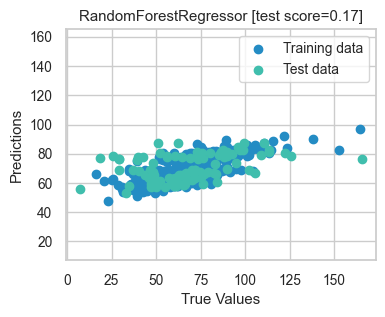

In [36]:
forest_regressor = RandomForestRegressor(max_depth=4)#, min_samples_leaf=1, n_estimators=50)
forest_regressor.fit(X_train, y_train)
y_pred = forest_regressor.predict(X_test)
score = forest_regressor.score(X_test, y_test)

y_train_pred = forest_regressor.predict(X_train)
plot_pred_vs_true(y_test, y_pred, score, 'RandomForestRegressor', y_train=y_train, y_train_pred=y_train_pred)


Affichons les métriques pour évaluer la performance de ce modèle.

In [37]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse:3.3} (NRMSE:{rmse/y_test.mean()*100:3.3})')

score = forest_regressor.score(X_test, y_test)
print(f'Coefficient of determination: {score:3.3}')

RMSE: 22.3 (NRMSE:32.9)
Coefficient of determination: 0.167


Explorons un peu plus en détails les prédictions.

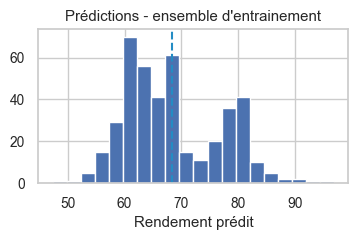

In [38]:
_ = plt.figure(figsize=(4,2))
plt.hist(y_train_pred, bins=20)
plt.title("Prédictions - ensemble d'entrainement")
plt.axvline(x=y_train.mean(), color=colors[1], linestyle='--')
plt.xlabel('Rendement prédit')
plt.show()

Il semble y avoir une distribution bi-modale.

In [39]:
thresh = 70
t1 = X_train.loc[y_train_pred < thresh,:].describe().T
t2 = X_train.loc[y_train_pred >= thresh,:].describe().T

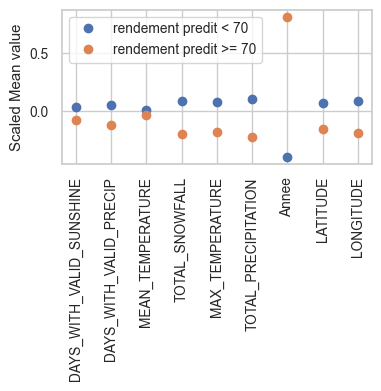

In [40]:
thresh = 70
plt.figure(figsize=(4,2))
X_train_scaled.loc[y_train_pred < thresh,:].describe().T['mean'].plot(marker='o', linewidth=0, 
                                                                  label=f'rendement predit < {thresh}')
X_train_scaled.loc[y_train_pred >= thresh,:].describe().T['mean'].plot(marker='o', linewidth=0,
                                                                        label=f'rendement predit >= {thresh}')
plt.xticks(range(X_train_scaled.shape[1]), X_train_scaled.columns, rotation=90)
plt.ylabel('Scaled Mean value')
plt.legend()
plt.show()
#t2 = X_train.loc[y_train_pred >= 70,:].describe().T

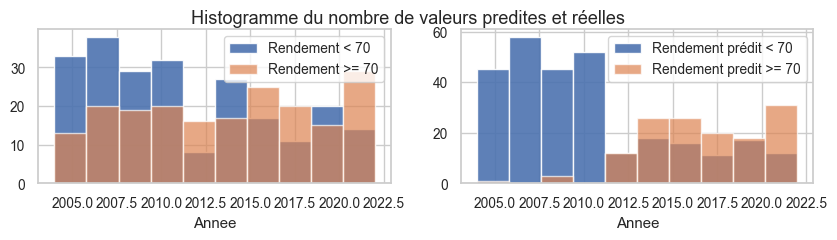

In [41]:
threshold = 70
_ = plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
var = 'Annee'
X_train.loc[y_train < threshold, var].hist(alpha=0.9, label=F'Rendement < {threshold}')
X_train.loc[y_train >= threshold, var].hist(alpha=0.7, label=F'Rendement >= {threshold}')
plt.xlabel(var)

plt.legend()

plt.subplot(1,2,2)
X_train.loc[y_train_pred < threshold, var].hist(alpha=0.9, label=F'Rendement prédit < {threshold}')
X_train.loc[y_train_pred >= threshold, var].hist(alpha=0.7, label=F'Rendement predit >= {threshold}')

plt.xlabel(var)
plt.suptitle('Histogramme du nombre de valeurs predites et réelles  ')
plt.legend()

plt.show()

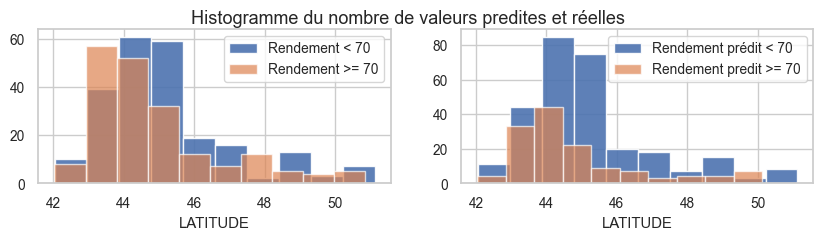

In [42]:
threshold = 70
_ = plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
var = 'LATITUDE'
X_train.loc[y_train < threshold, var].hist(alpha=0.9, label=F'Rendement < {threshold}')
X_train.loc[y_train >= threshold, var].hist(alpha=0.7, label=F'Rendement >= {threshold}')
plt.xlabel(var)

plt.legend()

plt.subplot(1,2,2)
X_train.loc[y_train_pred < threshold, var].hist(alpha=0.9, label=F'Rendement prédit < {threshold}')
X_train.loc[y_train_pred >= threshold, var].hist(alpha=0.7, label=F'Rendement predit >= {threshold}')

plt.xlabel(var)
plt.suptitle('Histogramme du nombre de valeurs predites et réelles  ')
plt.legend()

plt.show()

Choisissons un arbre et regardons-le

In [43]:
text_representation = tree.export_text(forest_regressor.estimators_[0])
print(text_representation)

|--- feature_6 <= 2014.50
|   |--- feature_4 <= 36.47
|   |   |--- feature_7 <= 44.79
|   |   |   |--- feature_8 <= -79.74
|   |   |   |   |--- value: [71.96]
|   |   |   |--- feature_8 >  -79.74
|   |   |   |   |--- value: [62.36]
|   |   |--- feature_7 >  44.79
|   |   |   |--- feature_4 <= 31.99
|   |   |   |   |--- value: [64.79]
|   |   |   |--- feature_4 >  31.99
|   |   |   |   |--- value: [55.83]
|   |--- feature_4 >  36.47
|   |   |--- feature_3 <= 96.26
|   |   |   |--- value: [25.45]
|   |   |--- feature_3 >  96.26
|   |   |   |--- value: [43.80]
|--- feature_6 >  2014.50
|   |--- feature_8 <= -78.95
|   |   |--- feature_5 <= 686.40
|   |   |   |--- feature_1 <= 302.75
|   |   |   |   |--- value: [46.02]
|   |   |   |--- feature_1 >  302.75
|   |   |   |   |--- value: [99.62]
|   |   |--- feature_5 >  686.40
|   |   |   |--- feature_8 <= -84.64
|   |   |   |   |--- value: [52.09]
|   |   |   |--- feature_8 >  -84.64
|   |   |   |   |--- value: [81.18]
|   |--- feature_8 >  -

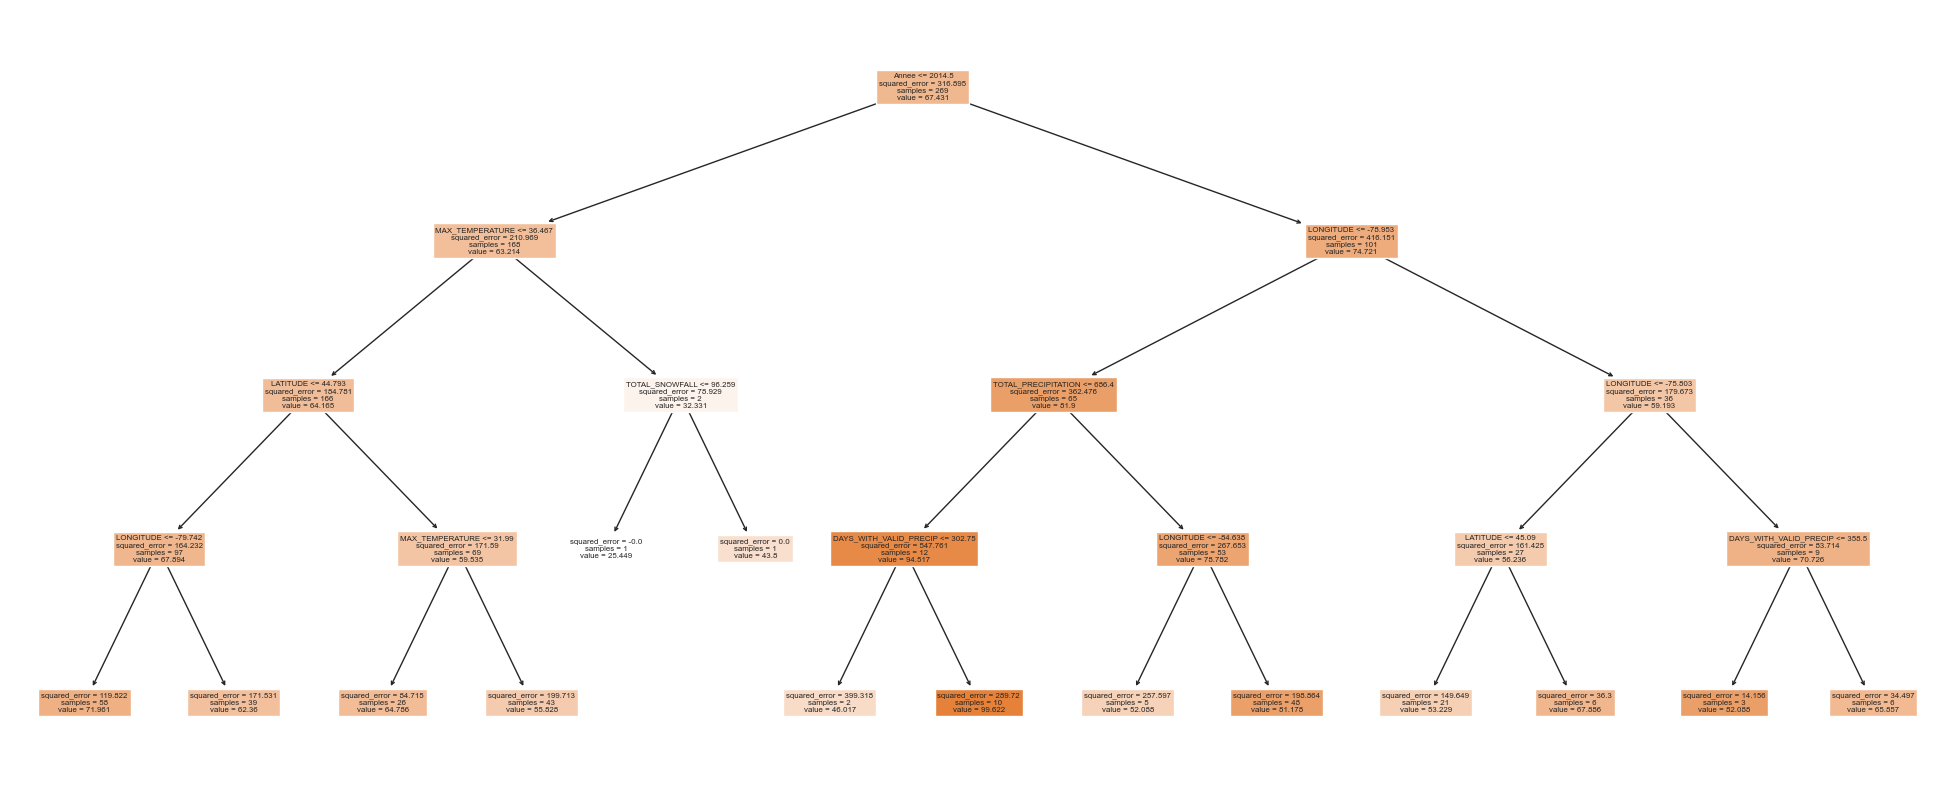

In [44]:
fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(forest_regressor.estimators_[0], 
                   feature_names=forest_regressor.feature_names_in_, 
                   class_names=['Rendement'],
                   filled=True)

Le résultat du modèle n'est pas très bon. Nous pouvons tout de même 
regarder quelles variables ont contribué le plus à la prédiction du rendement en récupérant l'`importance` (contribution au modèle) de chacune des caractéristiques.

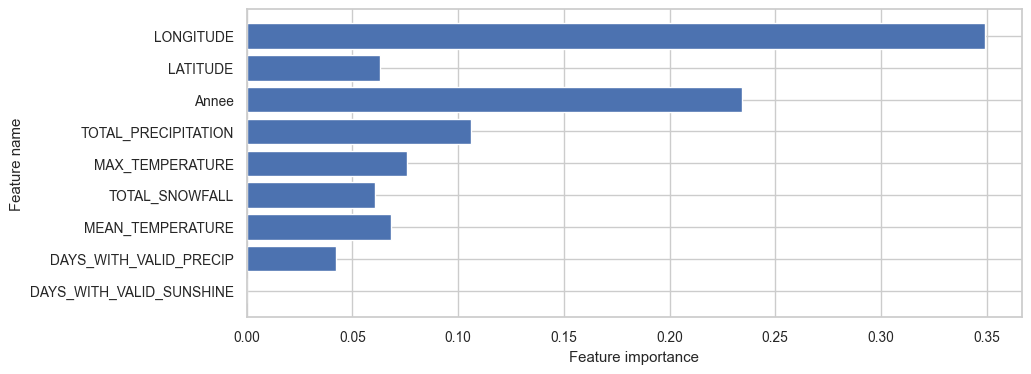

In [45]:
plt.figure(figsize=(10,4))
c_features = len(X_train_scaled.columns)
plt.barh(range(c_features), forest_regressor.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train_scaled.columns)
plt.show()

Nous pouvons voir que l'année et la longitude sont les deux variables qui ont le plus contribué.


### Régression linéaire

La régression linéaire met en relation une variable dépendante et une ou plusieurs variables indépendantes en supposant qu'il existe une corrélation et que la relation est explicative et linéaire.  

Elle sert à prédire la valeur d'une variable dépendante en utilisant les valeurs de variables indépendantes sous forme d'équations linéaires.  Elle peut être univariée ou multi-variée.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_ols_001.png' width='400'>

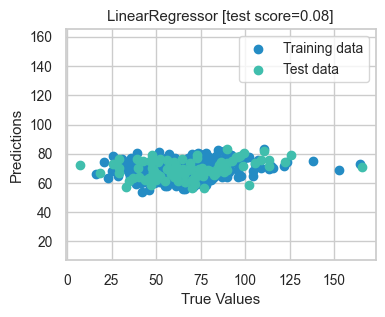

In [46]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train_scaled, y_train)
test_score = linear_regressor.score(X_test_scaled, y_test)
train_score = linear_regressor.score(X_train_scaled, y_train)
y_pred = linear_regressor.predict(X_test_scaled)
y_train_pred = linear_regressor.predict(X_train_scaled)
plot_pred_vs_true(y_test, y_pred, test_score, 'LinearRegressor', 
                  y_train=y_train, y_train_pred=y_train_pred)

In [47]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse:3.3} (NRMSE:{rmse/y_test.mean()*100:3.3})')

score = linear_regressor.score(X_test, y_test)
print(f'Coefficient of determination: {score:3.3}')

RMSE: 23.5 (NRMSE:34.6)
Coefficient of determination: -7.74e+04


Regardons les coefficients

In [48]:
print('intercept:', linear_regressor.intercept_)
print('coef:', list(zip(X_train.columns, linear_regressor.coef_) ))

intercept: 68.31915116691103
coef: [('DAYS_WITH_VALID_SUNSHINE', -0.0033487329103956856), ('DAYS_WITH_VALID_PRECIP', 1.5454813703507944), ('MEAN_TEMPERATURE', -0.847516771441259), ('TOTAL_SNOWFALL', -0.029895474141372752), ('MAX_TEMPERATURE', -2.237801530755035), ('TOTAL_PRECIPITATION', -2.1505216564952225), ('Annee', 4.108342578873376), ('LATITUDE', -3.293035596069024), ('LONGITUDE', -1.5314759367268473)]


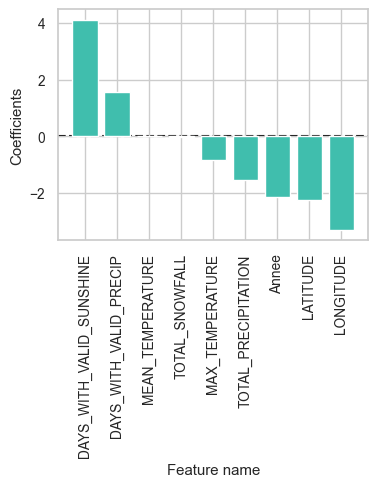

In [49]:
coefficients = pd.DataFrame(list(zip(X_train.columns, linear_regressor.coef_)), 
                            columns=['features', 'coefficients'])
coefficients.sort_values(by='coefficients', ascending=False, inplace=True)
plt.figure(figsize=(4,3))
plt.bar(range(len(coefficients)), coefficients.coefficients, color=colors[0])
plt.ylabel("Coefficients")
plt.xlabel("Feature name")
plt.xticks(np.arange(len(coefficients)), X_train.columns, rotation=90)
plt.axhline(y=0, color='black', linestyle='--', zorder=-1000)
plt.show()

### À votre tour 

<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

Que pouvez-vous conclure jusqu'à présent ? 

Les résultats des deux régresseurs testés ne sont pas très bons.  

In [50]:
res = pd.DataFrame(list(zip(y_pred, y_test)), columns=['pred', 'test'], index=y_test.index)
res['Annee'] = df.loc[y_test.index, 'Annee'].astype(int)
res['Region'] = df.loc[y_test.index, 'Region']
res['Ensemencee'] = df.loc[y_test.index, 'Ensemencee']
res['Recoltee'] = df.loc[y_test.index, 'Recoltee']
res['Rendement'] = df.loc[y_test.index, 'Rendement']
res['diff'] = res.pred - res.test
res.sort_values('diff', inplace=True)
res.head()

,pred,test,Annee,Region,Ensemencee,Recoltee,Rendement,diff
528,70.965113,165.176206,2013,Durham,896.966663,691.240364,165.176206,-94.211093
522,74.234949,122.149869,2021,Nipissing,2613.658317,2515.211939,122.149869,-47.914920
524,79.288627,125.695440,2021,Lambton,2954.099423,1537.928764,125.695440,-46.406813
505,58.655797,102.000000,2008,Huron,900.000000,800.000000,102.000000,-43.344203
518,71.741202,113.430796,2021,Timiskaming,2533.238061,2437.820802,113.430796,-41.689593


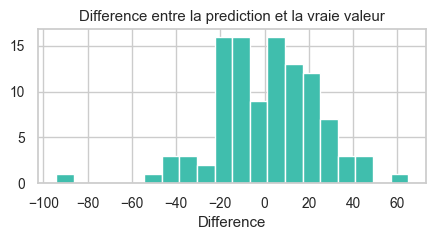

In [51]:
_ = plt.figure(figsize=(5,2))
plt.hist(res['diff'].values, bins=20, color=colors[0])
plt.xlabel('Difference')
plt.title('Difference entre la prediction et la vraie valeur')
plt.show()

### Régression linéaire avec la librairie statsmodels

Une autre librairie peut être utilisée pour effectuer une régression linéaire.  Il s'agit de la librairie `statsmodel`.

In [52]:
# Autre package pour effectuer des regressions rapidement.  Nous allons l'utiliser pour voir les p-values
X_sm = X_train_scaled.copy()
X_sm = sm.add_constant(X_sm)
model = sm.OLS(y_train, X_sm).fit()

In [53]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Rendement   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     4.355
Date:                Mon, 31 Jul 2023   Prob (F-statistic):           1.93e-05
Time:                        23:13:49   Log-Likelihood:                -1819.8
No. Observations:                 423   AIC:                             3660.
Df Residuals:                     413   BIC:                             3700.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

## Quels autres modèles pourrions-nous essayer ?

### À votre tour  
<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

Qu'en pensez-vous ? 

Chaque modèle est différent et certains peuvent être mieux adaptés que d'autres à certain problème ou jeu de données.

Pour optimiser les résultats, il faut tester différents pré-traitements, algorithmes/modèles et hyper-paramètres.   Ceci doit être fait en utilisant une stratégie de validation croisée pour s'assurer que le modèle final puisse généraliser à des données jamais vues.

Pour les petits jeux de données, la validation croisée permet aussi d'optimiser l'utilisation des données.

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
    
<img src="https://scikit-learn.org/stable/_static/ml_map.png" width='1000px'/>

## Pipelines de Scikit Learn 

Comme il existe un nombre élevé de combinaisons possibles à tester, nous nous retrouvons rapidement avec plusieurs expériences à gérer.

Pour tout résultat intéressant et moins intéressant, les paramètres utilisés doivent être conservés.  

Les `pipelines` de `scikit-learn` nous aide à nous organiser et permettent de sauver du temps et des lignes de code.

Nous pourrions aussi utiliser des logiciels comme kedro ou Knime.  L'application d'algorithmes d'apprentissage de façon automatique (auto ML de Google, auto_sklearn) est aussi de plus en plus populaire.  Des logiciels comme Neptune.ai permettent aussi d'organiser les résultats et les paramètres des expériences.

Attention !!  Sans être expert de tous les types de modèles, il ne faut pas les utiliser aveuglément.  Il faut s'assurer de lire la documentation, de comprendre la théorie de base, les options et arguments et les particularités des différentes implémentation (s'il y a lieu).

Une pipeline applique séquentiellement différentes opérations.

Dans les pipelines de `scikit-learn`, nous retrouvons 2 concepts importants:

* les transformateurs (transformer) qui offrent les fonctions `fit` et `transform`
* les estimateurs (estimators) qui offrent les fonctions`fit` et `predict`

La fonction `make_pipeline` gère l'enchainement des différentes étapes de pré-traitement et d'entrainement.

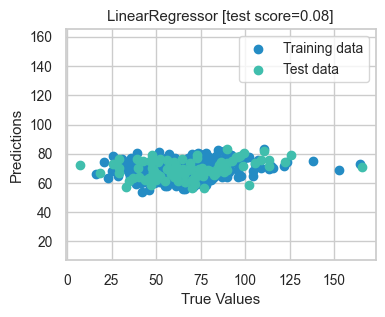

In [68]:
pipeline = make_pipeline(SimpleImputer(), StandardScaler(), 
                         LinearRegression(fit_intercept=True))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
test_score = pipeline.score(X_test, y_test)

y_train_pred = pipeline.predict(X_train)
plot_pred_vs_true(y_test, y_pred, test_score, 'LinearRegressor', 
                  y_train=y_train, y_train_pred=y_train_pred)

La classe `Pipeline` gère aussi l'enchainement séquentiel des différentes étapes.  Ici, nous avons besoin de nommer les étapes.  
Avec `make_pipeline`, les noms sont créés automatiquement.

Nous pouvons passer l'objet `pipeline` à la méthode `cross_val_score` pour effectuer la validation croisée. 

In [55]:
results = []
estimator_names = ['LinearRegression', 'RandomForestRegressor', 'DecisionTreeRegressor', 'KNeighborsRegressor',
                   'GradientBoostingRegressor', 'SVR']
for estimator in estimator_names:
    pipeline = Pipeline([ ('imputer', IterativeImputer(max_iter=10)),
                          ('scaler', StandardScaler()),
                          ('estimator', eval(estimator)()) 
                            ])
    cv = KFold(n_splits=10)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, n_jobs=-1)
    results.append([estimator, np.mean(scores), np.std(scores), 'Rendement'])
    
results = pd.DataFrame(results, columns=['Model', 'Mean Score', 'Std Score', 'Dataset'])
results

,Model,Mean Score,Std Score,Dataset
0,LinearRegression,-0.035301,0.210015,Rendement
1,RandomForestRegressor,0.092977,0.230574,Rendement
2,DecisionTreeRegressor,-0.733872,0.500876,Rendement
3,KNeighborsRegressor,-0.000497,0.191405,Rendement
4,GradientBoostingRegressor,0.006796,0.238016,Rendement
5,SVR,0.031271,0.118304,Rendement


Un coefficient de détermination négatif indique que quelque chose ne fonctionne pas.  Cela indique que le modèle de régression n'est pas capable de capturer la variation des données et qu'il effectue des prédictions moins précises qu'en utilisant simplement la moyenne.  

Quoi faire ?

* S'assurer que le code est correct 
* Vérifier les données tant les variables prédictives que la variable à prédire
* Retourner aux données pour comprendre le problème

Comme nous n'obtenons pas de très bons résultats, nous pouvons tester notre code avec des données sythétiques en utilisant la fonction `make_regression`.

In [56]:
X_tmp, y_tmp = make_regression(n_samples=X.shape[0], n_features=X.shape[1], random_state=random_seed)

results_tmp = []
for estimator in estimator_names:
    pipeline = make_pipeline(IterativeImputer(), StandardScaler(), eval(estimator)())
    cv = KFold(n_splits=10)
    scores = cross_val_score(pipeline, X_tmp, y_tmp, cv=cv, n_jobs=-1)
    results_tmp.append([estimator, np.mean(scores), np.std(scores), 'scikit-learn'])

results_tmp = pd.DataFrame(results_tmp, columns=['Model', 'Mean R2', 'Std Score', 'Dataset'])
results_tmp

,Model,Mean R2,Std Score,Dataset
0,LinearRegression,1.000000,0.000000,scikit-learn
1,RandomForestRegressor,0.766080,0.054608,scikit-learn
2,DecisionTreeRegressor,0.405661,0.156560,scikit-learn
3,KNeighborsRegressor,0.730416,0.044777,scikit-learn
4,GradientBoostingRegressor,0.878157,0.030166,scikit-learn
5,SVR,0.090277,0.022428,scikit-learn


### À votre tour 

<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

Que concluez-vous de ces résultats ?

## Trouver les bons paramètres et le bon modèle


En tenant compte de nos contraintes pratiques, nous voulons tester différents algorithmes sur les données traitées de différentes façons.  Nous voulons aussi optimiser les hyper-paramètres des algorithmes testés.  

Cela fait beaucoup de combinaisons possibles.  Les `pipeline`de `scikit-learn` favorisent la traçabilité, la reproductibilité et l'automatisation.


In [57]:
estimator_params = {'RandomForestRegressor': {'estimator__max_depth': [4, 6, 8, 10, 12]},
                    'SVR': {'estimator__kernel':  ['poly', 'rbf', 'sigmoid']},
                    'LinearRegression': {},
                    'KNeighborsRegressor': {},
                    'GradientBoostingRegressor': {}, 
                    'DummyRegressor': {}}

res = []
for estimator in estimator_params.keys():  
    pipeline = Pipeline([('imputer', None),('scaler', None), 
                         ('estimator', eval(estimator)())])
    parameters = {
        'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
        'imputer': [None, SimpleImputer(), IterativeImputer()]}
   
    parameters.update(estimator_params.get(estimator, {}))
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring="r2")  
    grid_search.fit(X_train, y_train) 
    cv_results = grid_search.cv_results_
    best_estimator = grid_search.best_estimator_     
    res.append([estimator, grid_search.best_score_, grid_search.best_params_, 
                cv_results, best_estimator]) 

In [69]:
res = pd.DataFrame(res, columns=['Model', 'Best_Score', 'Best_parameters', 
                                 'CV_Results', 'Best_estimator'])
res.to_csv('prediction_rendement_20230707.GBo.csv')

Regardons les résultats obtenus

In [72]:
res.sort_values('Best_Score', ascending=False, inplace=True)
res

,Model,Best_Score,Best_parameters,CV_Results,Best_estimator
0,RandomForestRegressor,0.177629,"{'estimator__max_depth': 8, 'imputer': Iterati...","{'mean_fit_time': [0.22390823364257811, 0.2227...","(IterativeImputer(), None, (DecisionTreeRegres..."
3,KNeighborsRegressor,0.117546,"{'imputer': None, 'scaler': StandardScaler()}","{'mean_fit_time': [0.0024063587188720703, 0.00...","(None, StandardScaler(), KNeighborsRegressor())"
1,SVR,0.085228,"{'estimator__kernel': 'poly', 'imputer': None,...","{'mean_fit_time': [0.0066010475158691405, 0.00...","(None, MinMaxScaler(), SVR(kernel='poly'))"
4,GradientBoostingRegressor,0.074225,"{'imputer': SimpleImputer(), 'scaler': Standar...","{'mean_fit_time': [0.09629325866699219, 0.0895...","(SimpleImputer(), StandardScaler(), ([Decision..."
2,LinearRegression,0.027640,"{'imputer': None, 'scaler': None}","{'mean_fit_time': [0.0029721736907958986, 0.00...","(None, None, LinearRegression())"
5,DummyRegressor,-0.005849,"{'imputer': None, 'scaler': None}","{'mean_fit_time': [0.0008219718933105469, 0.00...","(None, None, DummyRegressor())"


In [73]:
res['Best_estimator'][0][2]

RandomForestRegressor(max_depth=8)

À quoi ressemblent les résultats de validation croisée ? 

In [79]:
print(res.iloc[4]['Model'])
res['CV_Results'][4]

LinearRegression


{'mean_fit_time': array([0.09629326, 0.08953986, 0.09335699, 0.10199327, 0.09197416,
        0.08739357, 0.10451746, 0.09945984, 0.11789346, 0.10979977,
        0.10661988, 0.10327229]),
 'std_fit_time': array([0.00717965, 0.00110232, 0.00460193, 0.00908449, 0.00392068,
        0.00109041, 0.00664978, 0.00879459, 0.02087177, 0.00694071,
        0.00294285, 0.00123392]),
 'mean_score_time': array([0.00173244, 0.00184674, 0.00198045, 0.00219893, 0.00205722,
        0.00195541, 0.00240555, 0.002987  , 0.00217609, 0.00224376,
        0.00216341, 0.00214005]),
 'std_score_time': array([0.00015678, 0.00010768, 0.00028708, 0.00054826, 0.00047956,
        0.00012629, 0.00040842, 0.0012268 , 0.00015973, 0.00025905,
        0.0001269 , 0.00012915]),
 'param_imputer': masked_array(data=[None, None, None, None, SimpleImputer(),
                    SimpleImputer(), SimpleImputer(), SimpleImputer(),
                    IterativeImputer(), IterativeImputer(),
                    IterativeImputer(), I

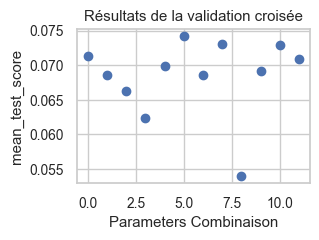

In [83]:
_ = plt.figure(figsize=(3,2))
var = 'mean_test_score'
plt.plot(res['CV_Results'][4][var], marker='o', linewidth=0)
plt.xlabel('Parameters Combinaison')
plt.ylabel(var)
plt.title('Résultats de la validation croisée')
plt.show()

### Calcul de différentes métriques pour les meilleurs modèles choisis.

Nous pouvons calculer différentes métriques pour évaluer les modèles. Les métriques nous renseignent sur différents aspects de l'apprentissage.  Il est donc essentiel de rapporter plus d'une métrique sous forme de tableau ou graphique.

L'évaluation finale se fait sur l'ensemble de test.

In [64]:
metric_names = ["mean_absolute_error", 'mean_squared_error', "r2_score"] # doit être le même nom que dans la librairie

mymetrics = []
for row in res.to_dict('records'):
    model = row['Model']
    estimator = row['Best_estimator']
    pred_test = estimator.predict(X_test)
    m = []
    for metric_name in metric_names:
        m.append(eval(f'{metric_name}(y_test, pred_test)'))
    mymetrics.append([model] + m)
mymetrics =  pd.DataFrame(mymetrics, columns=['Model'] + metric_names)

In [65]:
mymetrics

,Model,mean_absolute_error,mean_squared_error,r2_score
0,RandomForestRegressor,16.141818,498.197124,0.167573
1,SVR,17.533249,527.082564,0.119309
2,LinearRegression,18.238193,550.009162,0.081001
3,KNeighborsRegressor,17.612469,563.871352,0.057839
4,GradientBoostingRegressor,16.575454,514.332430,0.140613
5,DummyRegressor,18.713867,598.687934,-0.000335


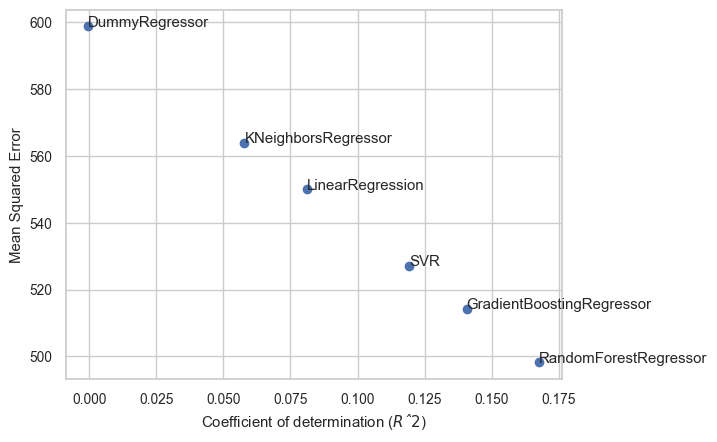

In [66]:
plt.scatter(mymetrics.r2_score, mymetrics.mean_squared_error)
for i in range(mymetrics.shape[0]):
    plt.text(mymetrics.r2_score[i], mymetrics.mean_squared_error[i], s=mymetrics.Model[i])
plt.ylabel('Mean Squared Error')
plt.xlabel('Coefficient of determination ($Rˆ2$)')
plt.show()

Voici un article s'intéressant à la prédiction du rendement: <br>
    https://www.frontiersin.org/articles/10.3389/fpls.2019.00621/full

Et un rapport produit dans le cadre d'une compétition:<br>
https://github.com/WizzX7/Morgan-Stanley-Quant-Challange/blob/main/quant_documentation.pdf
